[Quick Start](https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements)

In [1]:
# load environment
import os
from dotenv import load_dotenv
load_dotenv()


True

In [2]:
# load LLM from Ollama

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
# load search tool
from langchain_community.tools.tavily_search import TavilySearchResults

from crm_chatbot.tools.llm_choice import instantiate_chatllm

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

llm=instantiate_chatllm()
# bind tools to the llm
llm_with_tools = llm.bind_tools(tools)

In [3]:
# create a basic chatbot without tools
from typing import Annotated
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

binds_tools = True
def chatbot(state: State):
    if(binds_tools) :
        print("System: calling llm + tool binding.")
        return {"messages": [llm_with_tools.invoke(state["messages"])]}
    else :
        print("System: calling llm without tool binding.")
        return {"messages": [llm.invoke(state["messages"])]}


In [4]:
# Build a basic chatbot
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


In [5]:
# Streaming the chatbot
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


 <a id='run_chatbot'>Run the chatbot from the below cell.</a>

In [6]:
# Run the chatbot
while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Please explain LangGraph.
System: calling llm + tool binding.
Assistant: It seems like there might be some confusion or misunderstanding regarding "LangGraph." I couldn't find any specific well-known framework, library, or concept called exactly "LangGraph" in the context of programming languages or software development.

Could you please provide more details about what aspect of "LangGraph" you are interested in? Is it related to a particular technology stack, programming language feature, or a specific application domain? Providing additional context will help me give you a more accurate and useful answer.
User: quit
Goodbye!


# Add a tool node Manually

In [7]:
## Add a tool node by
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [8]:
# Creat a conditional edge from chatbot node to tools node
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        print("System: route to tool call.")
        return "tools"
    print("System: route to the END.")
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


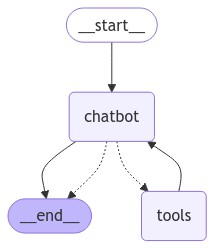

In [9]:
# Display the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

[Click here to run the chatbot](#run_chatbot)


# Use Prebuilt ToolNode

In [10]:
# replace BasicToolNode by the Prebuilt ToolNode
from langgraph.prebuilt import ToolNode, tools_condition

tool_node=ToolNode(tools=[tool])

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [11]:
# add memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)